In [1]:
# Make sure that you have the following installed on your machine to view interactive plots in jupyter lab
# https://github.com/matplotlib/ipympl#installation
# run 
#pip install ipympl
#jupyter labextension install @jupyter-widgets/jupyterlab-manager
#jupyter lab build

In [2]:
%matplotlib inline

In [3]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import writers

In [4]:
def calculate_weights(rows, cols, R):

    # dummy array to easily loop over coordinates
    agents = np.zeros((rows, cols))
    
    # for each agent store the distances to all other nodes
    distances = np.zeros((rows, cols, rows, cols))

    for i1, agent1 in np.ndenumerate(agents):
        x_coord_self = i1[1]
        y_coord_self = i1[0]

        for i2, agent2 in np.ndenumerate(agents):
            x_coord = i2[1]
            y_coord = i2[0]

            distance = np.sqrt((x_coord - x_coord_self)**2 + (y_coord - y_coord_self)**2)
            distances[y_coord_self][x_coord_self][y_coord][x_coord] = distance
    
    #print(distances[2][2])



    # for each agent store the angle to all of its neighbors
    angles = np.zeros((rows, cols, rows, cols))

    for i1, agent1 in np.ndenumerate(agents):
        x_coord_self = i1[1]
        y_coord_self = i1[0]

        for i2, agent2 in np.ndenumerate(agents):
            x_coord = i2[1]
            y_coord = i2[0]

            vec_1 = (1, 0)
            vec_2 = (x_coord - x_coord_self, y_coord - y_coord_self)

            c = np.dot(vec_1, vec_2)/np.linalg.norm(vec_1)/np.linalg.norm(vec_2) # -> cosine of the angle
            angle = np.arccos(np.clip(c, -1, 1)) # if you really want the angle

            angles[y_coord_self][x_coord_self][y_coord][x_coord] = angle
    
    #print(angles[2][2])



    # for each agent store the impact (weight) that all other nodes have on it.
    weights = np.zeros((rows, cols, rows, cols))

    for i1, agent1 in np.ndenumerate(agents):
        x_coord_self = i1[1]
        y_coord_self = i1[0]

        for i2, agent2 in np.ndenumerate(agents):
            x_coord = i2[1]
            y_coord = i2[0]

            distance = distances[y_coord_self][x_coord_self][y_coord][x_coord]
            angle = angles[y_coord_self][x_coord_self][y_coord][x_coord]

            weight = np.exp(- distance / R) * (1 + w + (1 - w) * np.cos(np.pi - angle))

            if distance > 3*R or distance < 0:
                weight = 0

            weights[y_coord_self][x_coord_self][y_coord][x_coord] = weight

        # normalize the weights so that the sum is equal to 1
        # before we can sum up all the weights for each agent, we have to make sure that there is no more nan in the data. nan was always the agent in focus, so it should be 0 that the agent does not influence himself.
        weights[np.isnan(weights)] = 0
        # K is normalizing factor
        K = np.sum(weights[y_coord_self][x_coord_self])
        weights[y_coord_self][x_coord_self] = np.divide(weights[y_coord_self][x_coord_self], K)
        
    #print(weights[2][2])
    
    return weights


In [17]:
def set_next_state(agents, weights):
    
    # loop over all agents and calcualte the weighted amount of people in active state that impact this agent
    for i1, agent1 in np.ndenumerate(agents):
        
        x_coord_self = i1[1]
        y_coord_self = i1[0]
        
        weights_agents = weights[y_coord_self, x_coord_self]
    
        state = agent1['state']
        substate = agent1['substate']
        threshold = agent1['threshold']
        
        if state == 1:
            if substate < 2:
                agent1['substate'] += 1
            else:
                agent1['next_state'] = 2
                agent1['substate'] = 0
        
        elif state == 2:
            if substate < 2:
                agent1['substate'] += 1
            else:
                agent1['next_state'] = 0
                agent1['substate'] = 0
                
        else:
            # current state: 0 (inactive)
            # calculate the probability that he becomes active
            active_agents_weight = 0
            
            for i2, agent2 in np.ndenumerate(agents):
                x_coord = i2[1]
                y_coord = i2[0]
                
                # sum over all the agents in the radius that have an influence on the agent in question
                if agent2['state'] == 1:
                    weight = weights_agents[y_coord, x_coord]
                    active_agents_weight += weight
        
            
            if active_agents_weight > threshold:
                # update agent to be in active state
                agent1['next_state'] = 1
                agent1['substate'] = 0

                
def update_state(agents):
    for i, agent in np.ndenumerate(agents):
        agent['state'] = agent['next_state']

        
def run_simulation(agents, weights, rows, cols, threshold, size_triggering_group, time_steps):
    
    res_aggregate_total = []
    res_state_only_total = []

    # initialise thresholds and states
    for i in range(rows):
        for j in range(cols):
            agents[i][j]['state'] = 0
            agents[i][j]['substate'] = 0
            agents[i][j]['next_state'] = 0
            agents[i][j]['threshold'] = np.random.uniform(threshold - 0.05, threshold + 0.05)

    
    # n = int(np.sqrt(size_triggering_group))
    agents_in_row = size_triggering_group[0]
    agents_in_col = size_triggering_group[1]
    for i in range(agents_in_row):
        for j in range(agents_in_col):
            agents[i + (int((rows - agents_in_col) / 2))][j+3]['state'] = 1
            agents[i + (int((rows - agents_in_col) / 2))][j+3]['next_state'] = 1
            
    for i in range(time_steps):
        res_aggregate = np.zeros(cols)
        res_state_only = np.zeros((rows, cols))
        
        # sum all cols up
        for index, agent in np.ndenumerate(agents):
            y_coord = index[0]
            x_coord = index[1]
            state = agent['state']
            
            res_state_only[y_coord][x_coord] = state
            
            if state == 1:
                res_aggregate[x_coord] += 1
                
        set_next_state(agents, weights)
        
        # update all agents synchronously
        update_state(agents)
        
        res_aggregate_total.append(res_aggregate)
        res_state_only_total.append(res_state_only)
        
        
        # Check if wave died -> all agents have state 0 at this timestep
        # If yes -> return False
        if not np.any(res_aggregate):
            return res_state_only_total, False
        
        # check if wave has already reached the last column of the stadium
        # thus, if amount of 1's is above 0.5 * number of rows -> wave has made it until the end
        if res_aggregate[-1] > (0.5 * rows):
            return res_state_only_total, True
        
    # There have been agents in state 1 in every timestep but the wave didn't make it to the end
    # still a wave was created and running -> return True
    return res_state_only_total, True
    

In [6]:
rows = 25
cols = 75

R = 2
# factor of how much more people to the right of a person have an influence compared to the people on the left
w = 0.25

# weights can be pre calculated as they won't change during simulation
weights = calculate_weights(rows, cols, R)

/home/dario/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


0.25 4 0 NO wave occured
0.25 4 1 NO wave occured
0.25 4 2 NO wave occured
0.25 4 3 NO wave occured
0.25 4 4 NO wave occured
0.25 4 5 NO wave occured
0.25 4 6 NO wave occured
0.25 4 7 NO wave occured
0.25 4 8 NO wave occured
0.25 4 9 NO wave occured
0.25 4 10 NO wave occured
0.25 4 11 NO wave occured
0.25 4 12 NO wave occured
0.25 4 13 NO wave occured
0.25 4 14 NO wave occured
0.25 (2, 2) probability of wave: 0.0
0.25 6 0 NO wave occured
0.25 6 1 NO wave occured
0.25 6 2 NO wave occured
0.25 6 3 NO wave occured
0.25 6 4 NO wave occured
0.25 6 5 NO wave occured
0.25 6 6 NO wave occured
0.25 6 7 NO wave occured
0.25 6 8 NO wave occured
0.25 6 9 NO wave occured
0.25 6 10 NO wave occured
0.25 6 11 NO wave occured
0.25 6 12 NO wave occured
0.25 6 13 NO wave occured
0.25 6 14 NO wave occured
0.25 (2, 3) probability of wave: 0.0
0.25 9 0 NO wave occured
0.25 9 1 NO wave occured
0.25 9 2 NO wave occured
0.25 9 3 NO wave occured
0.25 9 4 NO wave occured
0.25 9 5 wave occured
0.25 9 6 NO wave oc

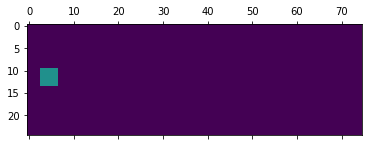

In [18]:
# threshold for each agent to become active, will be randomly chosen in the interval +-0.05
thresholds = [.25, .26, .27, .28, .29, .3]
# fraction of people on the two most left columns that intitiate the wave
size_triggering_groups = [(2,2), (2,3), (3,3), (3,4), (4,4)]

time_steps = 50

fig = plt.figure()
ax = fig.add_subplot(111)

# animation function.  This is called sequentially
def animate(i, res, colax):
    colax.set_data(res[i])
    return colax

probabilities = np.zeros((len(thresholds), len(size_triggering_groups)))

for i1, threshold in enumerate(thresholds):
    
    for i2, size_triggering_group in enumerate(size_triggering_groups):
        
        realizations = 0
        wave_occured = 0

        for i in range(15):
            # each agent has one the following states
            # 0: inactive
            # 1: active
            # 2: refracter
            agents = np.zeros((rows, cols), dtype=[('state', np.int), ('substate', np.int), ('next_state', np.int), ('threshold', np.float)])

            res_states_only, wave = run_simulation(agents, weights, rows, cols, threshold, size_triggering_group, time_steps)
            
            if wave:
                print(threshold, size_triggering_group[0] * size_triggering_group[1], i, 'wave occured')
                wave_occured += 1
            else:
                print(threshold, size_triggering_group[0] * size_triggering_group[1], i, 'NO wave occured')
            realizations += 1

            # initialize the plot (each color 0,1,2 is represented once so that the colors are also there for the next frames in the animation)
            initial = np.zeros((rows, cols))
            initial[0][1] = 1
            initial[0][2] = 2
            cax = ax.matshow(initial)

            # call the animator
            # blit=True means only re-draw the parts that have changed
            anim = animation.FuncAnimation(fig, animate, fargs=(res_states_only, cax), frames=len(res_states_only))
            writers.reset_available_writers()

            # On windows/linux make sure to have ffmpeg installed before running this cell
            # https://ffmpeg.org/
            # on a mac you can simply use brew to install: brew install ffmpeg
            anim.save('laOla-' + str(threshold) + '-' + str(size_triggering_group[0] * size_triggering_group[1]) + '-' + str(i) +'.mp4', writer="ffmpeg", fps=5)
        
        p = wave_occured / realizations
        print(threshold, size_triggering_group, 'probability of wave:', p)
        probabilities[i1][i2] = p


In [ ]:
# def get_index(value,matrix):
#     for i in range(len(matrix)):
#         for j in range(len(matrix[0])):
#             if value == matrix[j][i]:
#                 return (j,i)


# def findabsoluteMaxofft2(matrix):
#     four_matrix = np.fft.fft2(matrix)
#     np.save('four_matrix', four_matrix)
#     absolute_four = np.absolute(four_matrix)
#     np.save('four_matrix_absolute', absolute_four)
    
#     np.save('results_rows_aggregated', res_row_aggregated)
    
#     max_value = np.max(four_matrix)
#     position = get_index(max_value, four_matrix)    
    
#     return max_value, position

In [ ]:
# results = findabsoluteMaxofft2(res_row_aggregated)
# max_value = results[0]
# print(max_value)

In [ ]:
# position = results[1]
# print(position)

In [ ]:
#plt.figure(1)
#plt.plot(timevariable, max_values)
#plt.show()

[[0.25, 0.25, 0.25, 0.25, 0.25], [0.26, 0.26, 0.26, 0.26, 0.26], [0.27, 0.27, 0.27, 0.27, 0.27], [0.28, 0.28, 0.28, 0.28, 0.28], [0.29, 0.29, 0.29, 0.29, 0.29], [0.3, 0.3, 0.3, 0.3, 0.3]]
[[4, 6, 9, 12, 16], [4, 6, 9, 12, 16], [4, 6, 9, 12, 16], [4, 6, 9, 12, 16], [4, 6, 9, 12, 16], [4, 6, 9, 12, 16]]
[[0.         0.         0.06666667 0.73333333 1.        ]
 [0.         0.         0.         0.53333333 1.        ]
 [0.         0.         0.         0.13333333 1.        ]
 [0.         0.         0.         0.         1.        ]
 [0.         0.         0.         0.         0.8       ]
 [0.         0.         0.         0.         0.        ]]


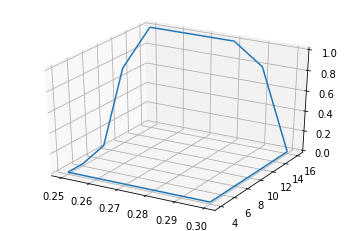

In [29]:
from mpl_toolkits.mplot3d import Axes3D

threshold_plot = [[threshold] * len(size_triggering_groups) for threshold in thresholds]
triggering_groups_plot = [[group[0] * group[1] for group in size_triggering_groups]] * len(thresholds)
print(threshold_plot)
print(triggering_groups_plot)
print(probabilities)

fig = plt.figure() 
wf = fig.add_subplot(111, projection='3d') 

wf.plot_wireframe(threshold_plot, triggering_groups_plot, probabilities, rstride=10, cstride=10) 
plt.show()
